 # please re-start kernel if these packages are installed for the first time

In [1]:
# ! pip install -e /user/hwang/Jupyter_notebooks/pkgs/objFuncs_REA
# ! pip install -e /user/hwang/Jupyter_notebooks/pkgs/pyBO

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
import datetime
import concurrent
from epics import caget

In [3]:
from objFuncs.REA_maximize_FC import maximize_FC1448 as maximize_FC
import objFuncs
from objFuncs.util import plot_obj_history
from pyBO import pyBO

[18:57:19.759] INFO: phantasy.library.operation.core: Load new machine: 'FRIB', segment: 'LINAC'
[18:57:19.760] INFO: phantasy.library.parser.config: Importing FRIB from /projects/rea3/AP-ReA/apps/.phyapps/phantasy-machines/FRIB
[18:57:19.762] INFO: phantasy.library.parser.config: Loading machine configuration from /projects/rea3/AP-ReA/apps/.phyapps/phantasy-machines/FRIB/phantasy.ini
[18:57:19.764] INFO: phantasy.library.operation.lattice: Loading segment: 'LINAC'


   _test : False
   _ensure_set_timeout : 30
   _ensure_set_timewait_after_ramp : 0.25
   _fetch_data_time_span : 2.05
   _return_obj_var : False
   _check_chopper_blocking : False


[18:57:19.958] INFO: phantasy.library.operation.lattice: UNICORN policy will be loaded from /projects/rea3/AP-ReA/apps/.phyapps/phantasy-machines/unicorn/unicorn-data.xls.
[18:57:19.959] WARNING: phantasy.library.operation.lattice: No aligment data is read.
[18:57:19.960] INFO: phantasy.library.operation.lattice: Device polarity data is loaded from /projects/rea3/AP-ReA/apps/.phyapps/phantasy-machines/polarity/polarity_data.csv.
[18:57:19.961] INFO: phantasy.library.operation.lattice: Loading PV data from CSV/SQLite: /projects/rea3/AP-ReA/apps/.phyapps/phantasy-machines/FRIB/linac/all_channels.csv
[18:57:19.962] INFO: phantasy.library.pv.datasource: Set source to be CSV table: all_channels.csv.
[18:57:20.515] INFO: phantasy.library.operation.lattice: Model data directory: /user/rea3/phantasy_data/20240315/model_data/data_185720
[18:57:20.565] INFO: phantasy.library.operation.lattice: Found 13828 PVs in 'LINAC'.
[18:57:22.575] INFO: phantasy.library.operation.lattice: 'LINAC' has 1353 e

In [4]:
from pyBO import pyBO

In [5]:
objFuncs._global_machineIO._test = False
objFuncs._global_machineIO._fetch_data_time_span = 2.55
objFuncs._global_machineIO._ensure_set_timewait_after_ramp = 0.25
# objFuncs._global_machineIO.fetch_data = objFuncs.construct_machineIO._manual_fetch_data

objFuncs._global_machineIO.view()

   _test : False
   _ensure_set_timeout : 30
   _ensure_set_timewait_after_ramp : 0.25
   _fetch_data_time_span : 2.55
   _return_obj_var : False
   _check_chopper_blocking : False
   _n_popup_ramping_not_OK : 0
   _verbose : False


In [6]:
budget = 60
n_init = 40

In [8]:
ion = caget("REA_EXP:ELMT")
Q = int(caget("REA_EXP:Q"))
A = int(caget("REA_EXP:A"))
AQ = A/Q
ion = str(A)+ion+str(Q)
print(ion, 'A/Q=',AQ)

20Ne9 A/Q= 2.2222222222222223


In [26]:
now0 = datetime.datetime.now()
now0str = str(now0)[:str(now0).rfind(':')].replace(' ','_').replace(':','').replace('-','')
fname = '[REA][pyBO]'+now0str+'_'+ion+'_FC1448'
fname

'[REA][pyBO]20240315_1922_20Ne9_FC1448'

# Decision parameters and range

In [27]:
decision_CSETs = [    
#      'REA_CM01:DCV_D1123:I_CSET',
#      'REA_CM01:DCH_D1123:I_CSET',
#      'REA_CM01:DCH_D1139:I_CSET',
#      'REA_CM01:DCV_D1139:I_CSET',
#      'REA_BTS25:DCH_D1172:I_CSET',
#      'REA_BTS25:DCV_D1172:I_CSET',
#      'REA_BTS26:DCH_D1219:I_CSET',
#      'REA_BTS26:DCV_D1219:I_CSET',
#      'REA_BTS30:DCH_D1270:I_CSET',
#      'REA_BTS30:DCV_D1270:I_CSET',
       'REA_BTS30:DCH_D1305:I_CSET',
       'REA_BTS30:DCV_D1305:I_CSET',
       'REA_BTS30:DCH_D1345:I_CSET',
       'REA_BTS30:DCV_D1345:I_CSET',
#     'REA_BTS34:DCH_D1413:I_CSET',
#     'REA_BTS34:DCV_D1413:I_CSET',
#     'REA_BTS34:DCH_D1431:I_CSET',
#     'REA_BTS34:DCV_D1431:I_CSET',
#     'REA_CM01:SOL_D1123:I_CSET',
#     'REA_CM01:SOL_D1139:I_CSET'
    ]

In [28]:
decision_min = [-35,-35,-35,-35]
decision_max = [35,35,35,35]
#decision_min = [-30]*6
#decision_max = [ 30]*6
decision_tols = [0.6,0.6,0.6,0.6]
#decision_tols = [0.6]*len(decision_CSETs)
print(decision_min)
print(decision_max)
print(decision_tols)

[-35, -35, -35, -35]
[35, 35, 35, 35]
[0.6, 0.6, 0.6, 0.6]


In [29]:
assert len(decision_CSETs) == len(decision_min) == len(decision_max)
if decision_tols is not None:
    assert len(decision_CSETs) == len(decision_tols) 
assert np.all(np.array(decision_min)<np.array(decision_max))

# Objectives

### manual definition of obj

In [30]:
objective_goal   = {'REA_BTS34:MTER_N0001:I_RD': {'more than': 20.0e-12}}
objective_weight = {'REA_BTS34:MTER_N0001:I_RD': 1}
objective_norm   = {'REA_BTS34:MTER_N0001:I_RD': 0.5e-11}

### regularization

### construct objectives class

In [31]:
obj = maximize_FC(
    decision_CSETs= decision_CSETs,
    decision_min  = decision_min,
    decision_max  = decision_max,
    decision_tols = decision_tols,
    objective_goal = objective_goal,
    objective_weight = objective_weight,
    objective_norm = objective_norm,
    objective_fill_none_by_init = True,
)

======== class info ========
init_time: 2024-03-15 19:23:06.137643
class_hierarchy: [
    maximize_FC1448, maximize_FC, objFuncGoals
    objFuncBase]
machineIO: <objFuncs.construct_machineIO.construct_machineIO object at 0x7f29d80c0340>
decision_CSETs: [
    REA_BTS30:DCH_D1305:I_CSET, REA_BTS30:DCV_D1305:I_CSET, REA_BTS30:DCH_D1345:I_CSET
    REA_BTS30:DCV_D1345:I_CSET]
decision_min: [-35. -35. -35. -35.]
decision_max: [35. 35. 35. 35.]
decision_bounds: [[-35  35]
 [-35  35]
 [-35  35]
 [-35  35]]
decision_RDs: [
    REA_BTS30:DCH_D1305:I_RD, REA_BTS30:DCV_D1305:I_RD, REA_BTS30:DCH_D1345:I_RD
    REA_BTS30:DCV_D1345:I_RD]
decision_tols: [0.6 0.6 0.6 0.6]
decision_couplings: None
history_buffer_size: None
logging_frequency: inf
logging_tag: 
logging_fname: None
x0: [23.91985245  3.77561025 -7.00000199 -3.01719263]
objective_weight: {'REA_BTS34:MTER_N0001:I_RD': 1.0}
objective_goal: {'REA_BTS34:MTER_N0001:I_RD': {'more than': 2e-11}}
objective_norm: {'REA_BTS34:MTER_N0001:I_RD': 5e-12}


 # Prepare plot callbacks

In [32]:
# define what to plot
plot_CSETs = plot_obj_history(
                obj.history['decision_CSETs'],
                title = 'decision_CSETs',
                inline = True,
                )
plot_RDs = plot_obj_history(
                obj.history['objective_RDs'],
                title = 'objective_RDs',
                inline = True,
                )
plot_objs = plot_obj_history(
            obj.history['objectives'],
            title = 'objectives',
            inline = True,
            )
callbacks = [plot_CSETs,plot_RDs,plot_objs]


# evaluate objective and plot
def obj_callbacks(x):
    return obj(x,callbacks=callbacks)

# Run BO



### run BO until budget exhaust

scipy version mismatch. 'scipy.stat.qmc' is not imported. Using custom halton seqeunce instead


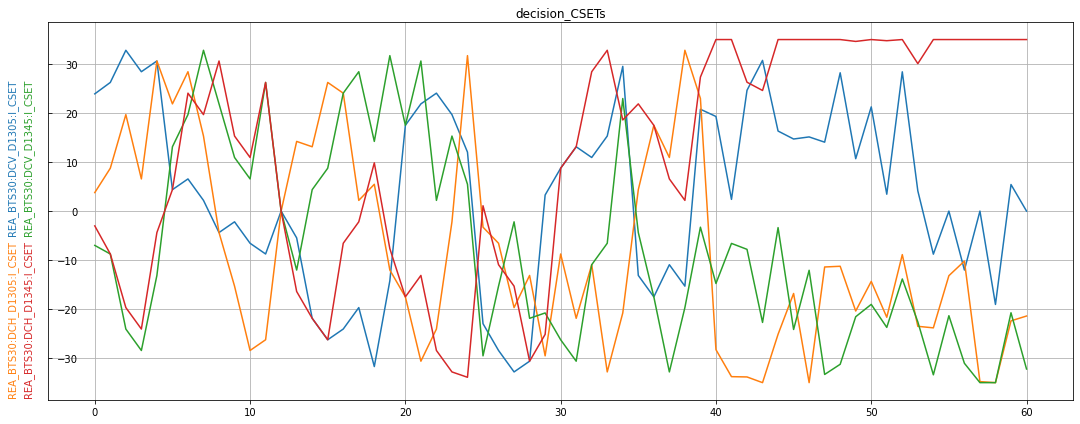

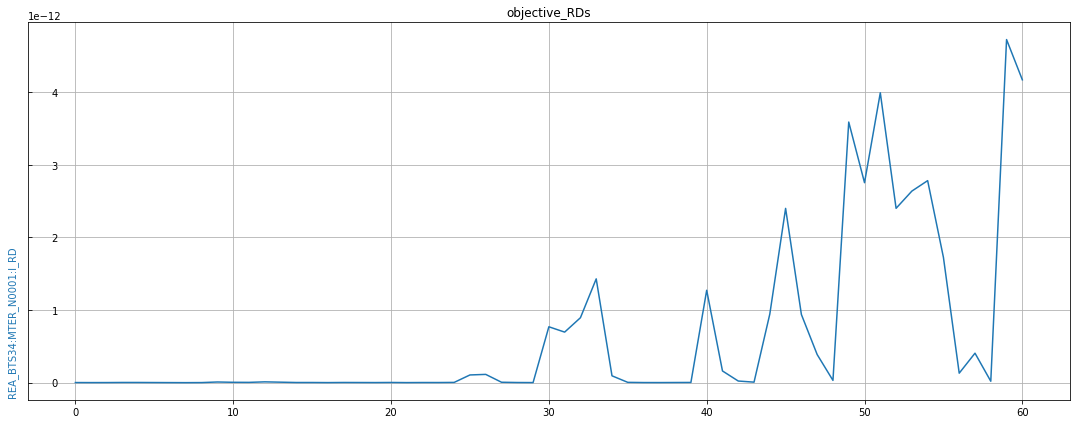

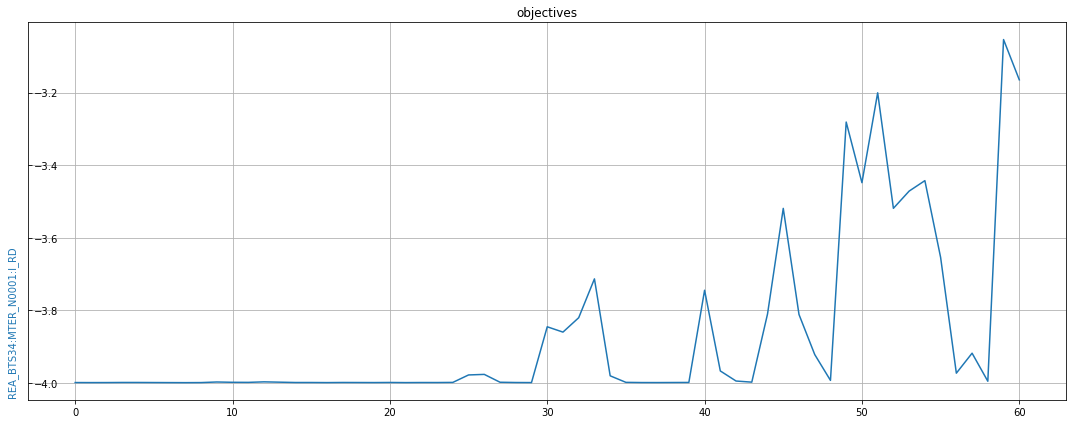

[████████████████████████████████████████] 100%/100%



In [33]:
# run optimizer
bo, X_pending, Y_pending_future = pyBO.runBO(
                                    obj_callbacks,  
                                    bounds=obj.decision_bounds,
                                    n_init=n_init,
                                    x0 = obj.x0,
                                    budget = budget,
                                    batch_size=1,
                                    path="./log/",
                                    tag=fname+'_pyBO_history',
                                    write_log = False)
for f in callbacks:
    f.close()

In [34]:
# if python raised error, check the training data collected unitl now. x,y should have same number of rows 
# x = np.array(obj.history['decision_RDs']['values'])
# y = np.array(obj.history['objectives']['values'])
# print(x.shape, y.shape)

In [35]:
# if python raised error, use the following to re-use all the data until now
# bo, X_pending, Y_pending_future = pyBO.runBO(
#     obj_callbacks,  
#     bounds=obj.decision_bounds,
#     n_init=n_init,
#     x0 = np.array(obj.history['decision_RDs']['values']),
#     y0 = np.array(obj.history['objectives']['values']),
#     budget = budget,
#     batch_size=1,
#     path="./log/",
#     tag=fname+'_pyBO_history',
#     write_log = False)
# for f in callbacks:
#     f.close()

### Fine Tune near current best

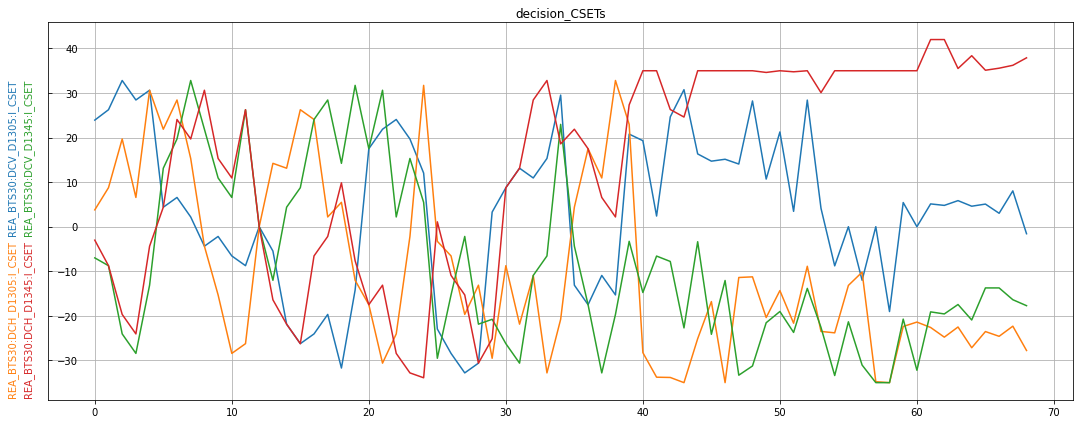

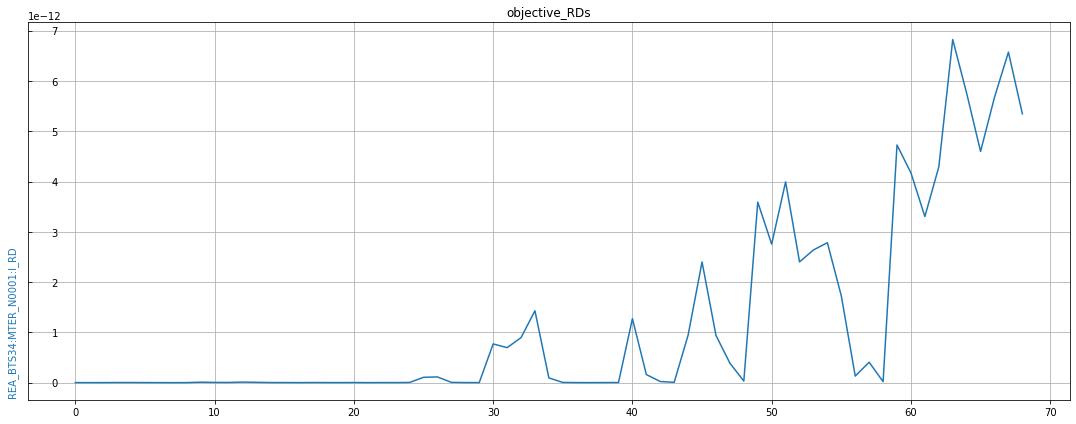

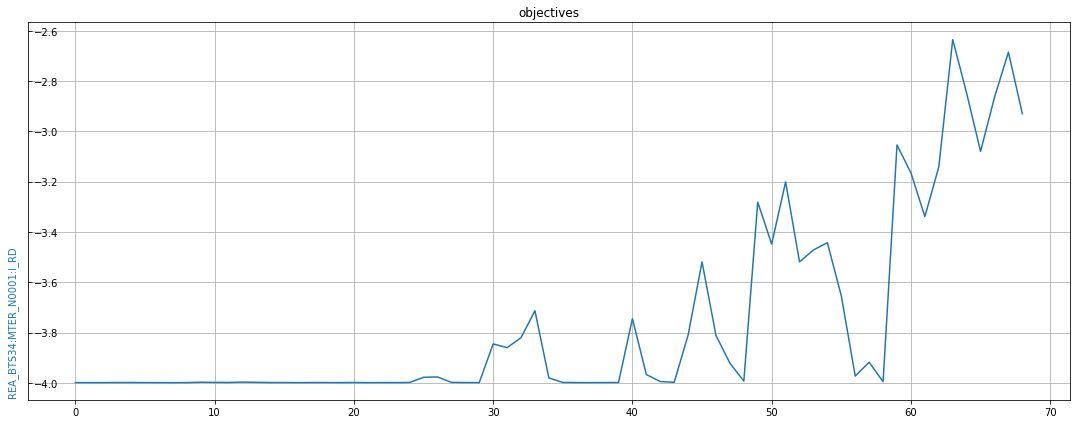

[████████████████████████████████████████] 100%/100%



In [36]:
# local optimization near the best_solution
delta = 0.1*(obj.decision_bounds[:,1]-obj.decision_bounds[:,0])
beta = 1
for i in range(1):
    x_best,y_best = bo.best_sofar()
    beta *= 0.5
    bounds_around_best = np.array([(x-d, x+d) for d, x in zip(delta,x_best)])
    acquisition_func_args = {'beta':beta}

    X_pending, Y_pending_future= bo.loop( 
                                    n_loop=8,  # number of additional optimization interation
                                    func_obj = obj_callbacks,
                                    bounds = bounds_around_best,
                                    acquisition_func_args = acquisition_func_args,
                                    X_pending = X_pending, 
                                    Y_pending_future = Y_pending_future,
                                    batch_size = 1,
                                    write_log = False,
                                    )
for f in callbacks:
    f.close()

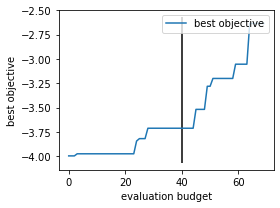

In [37]:
fig,ax = plt.subplots(figsize=(4,3))
ax = bo.plot_obj_history(ax=ax,plot_best_only=True)
ax.vlines(n_init,*ax.get_ylim(),color='k')
fig.tight_layout()
# fig.savefig(fname+'_history.png',dpi=90)

In [38]:
# set to best solution 
x_best,y_best_old = bo.best_sofar()
y_best_new = obj(x_best)
print(x_best,y_best_old[0],y_best_new)   # check if best solution objective value is consistent

[  5.8502665  -22.51030482 -17.46432642  35.50655783] -2.6346992601479706 -2.9980599880023995


In [39]:
now1 = datetime.datetime.now()
now1str = str(now1)[:str(now1).rfind(':')].replace(' ','_').replace(':','').replace('-','')
time_delta = now1 - now0
print("time took:",str(time_delta.total_seconds()/60)[:4],'min')

time took: 8.60 min


In [40]:
obj.write_log(fname='./log/'+fname)

only .pkl file extension is accepted. saving to: ./log/[REA][pyBO]20240315_1922_20Ne9_FC1448.pkl


# Visualize Surrogate model

In [41]:
# fixed_values_for_each_dim = {2:x_best[2],3:x_best[3]}  # fix values to visualize high dim surrogate model
fixed_values_for_each_dim = None              # do not fix values but project maximum. Can take long time to plot
batch_size = 1

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%



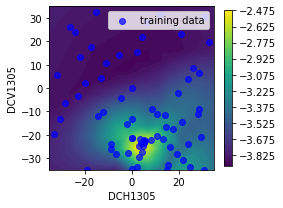

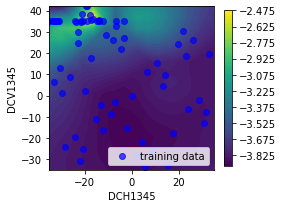

In [42]:
for i in range(int(len(decision_CSETs)/2)):
    fig,ax = plt.subplots(figsize=(4,3))
    bo.plot_model_2D_projection(project_maximum=True,
                                dim_xaxis = 2*i,
                                dim_yaxis = 2*i+1,
                                grid_ponits_each_dim = 16,
                                fixed_values_for_each_dim=fixed_values_for_each_dim,
                                fig=fig,ax=ax);
    ax.legend()
    pv_x = obj.decision_CSETs[2*i]
    pv_y = obj.decision_CSETs[2*i+1]
    pv_x = pv_x[pv_x.find(':')+1:]
    pv_y = pv_y[pv_y.find(':')+1:]
    pv_x = pv_x[:pv_x.find(':')].replace('_D','')
    pv_y = pv_y[:pv_y.find(':')].replace('_D','')
    ax.set_xlabel(pv_x)
    ax.set_ylabel(pv_y)
    fig.tight_layout()
#     fig.savefig(fname+'_'+pv_x+'_'+pv_y+'_.png',dpi=90)